In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import math

import sys


In [2]:
# 물질 설정 및 Refractive Index 설정
mp.verbosity(1)
um_scale = 1

Air = mp.Medium(index=1.0)
Si_frq1 = 3.6636779088975473
Si_gam1 = 0.0
Si_sig1 = 7.3201281378957015
Si_frq2 = 2.7935818128476333
Si_gam2 = 0.17126010693525032
Si_sig2 = 3.454969712267653


Si_susc = [
    mp.LorentzianSusceptibility(frequency=Si_frq1, gamma=Si_gam1, sigma=Si_sig1),
    mp.LorentzianSusceptibility(frequency=Si_frq2, gamma=Si_gam2, sigma=Si_sig2),
]
Si = mp.Medium(
    epsilon=1, E_susceptibilities=Si_susc)

In [3]:
resolution = 1000 # 해상도
design_region_width = 0.01 # 디자인 영역 x
design_region_width_y = 0.01 # 디자인 영역 y
design_region_height = 2 # 디자인 영역 높이 z
pml_size = 1.0 # PML 영역 크기

In [4]:
# 시뮬레이션 공간 설정
Sx = design_region_width
Sy = design_region_width_y
Sz = 2 * pml_size + design_region_height + 1 + 5
cell_size = mp.Vector3(0, 0, Sz)

In [5]:
wavelengths = np.array([0.41*um_scale, 0.43*um_scale, 0.45*um_scale, 0.51*um_scale, 0.54*um_scale, 0.57*um_scale, 0.64*um_scale, 0.68*um_scale, 0.72*um_scale])
# wavelengths = np.array([1.5])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

In [6]:
minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

In [7]:
pml_layers = [mp.PML(thickness = pml_size, direction = mp.Z)]

In [8]:
width = 0.1
fcen_red0 = frequencies[6]
fwidth_red0 = width * fcen_red0
fcen_red1 = frequencies[7]
fwidth_red1 = width * fcen_red1
fcen_red2 = frequencies[8]
fwidth_red2 = width * fcen_red2

fcen_green0 = frequencies[3]
fwidth_green0 = width * fcen_green0
fcen_green1 = frequencies[4]
fwidth_green1 = width * fcen_green1
fcen_green2 = frequencies[5]
fwidth_green2 = width * fcen_green2

fcen_blue0 = frequencies[0]
fwidth_blue0 = width * fcen_blue0
fcen_blue1 = frequencies[1]
fwidth_blue1 = width * fcen_blue1
fcen_blue2 = frequencies[2]
fwidth_blue2 = width * fcen_blue2

In [9]:
source_center = [0, 0, Sz / 2 - pml_size] # Source 위치

src_0 = mp.GaussianSource(frequency=fcen_red2, fwidth=fwidth_red2, is_integrated=True)


source = [mp.Source(src_0, component=mp.Ey, center=source_center)]


In [10]:
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(0, 0, Nz), Air, Si, grid_type="U_MEAN")



In [11]:
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - pml_size - 2),
        size=mp.Vector3(design_region_width, design_region_width_y, design_region_height),
    ),
)


In [12]:
geometry = [
    mp.Block(
        center=design_region.center, size=mp.Vector3(mp.inf, mp.inf, 0.2 * um_scale), material=Si
    )
]

In [13]:
sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    extra_materials=[Si],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_2 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_3 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_4 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_5 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_6 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_7 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_8 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_9 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_10 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_11 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,FourierFields_3, FourierFields_4, FourierFields_5 ,FourierFields_6, FourierFields_7, FourierFields_8,FourierFields_9, FourierFields_10, FourierFields_11]

# In[16]:


# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
def J_0(fields_0, fields_1, fields_2,fields_3, fields_4, fields_5,fields_6, fields_7, fields_8,fields_9, fields_10, fields_11):
    return npa.mean(npa.abs(fields_0[6,:]) ** 2) + npa.mean(npa.abs(fields_1[7,:]) ** 2) + npa.mean(npa.abs(fields_2[8,:]) ** 2) + npa.mean(npa.abs(fields_3[3,:]) ** 2) + npa.mean(npa.abs(fields_4[4,:]) ** 2) + npa.mean(npa.abs(fields_5[5,:]) ** 2) + npa.mean(npa.abs(fields_6[0,:]) ** 2) + npa.mean(npa.abs(fields_7[1,:]) ** 2) + npa.mean(npa.abs(fields_8[2,:]) ** 2) + npa.mean(npa.abs(fields_9[3,:]) ** 2) + npa.mean(npa.abs(fields_10[4,:]) ** 2) + npa.mean(npa.abs(fields_11[5,:]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-5
)


In [14]:
opt.sim.reset_meep()
#simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(mp.inf, mp.inf, 0), material=Air
    )
]

In [15]:

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[Si],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 100

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ex, center=source_center)]
opt.sim.change_sources(source)


In [16]:
#reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - pml_size - 0.3)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

#transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


#pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)


#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-11))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00118017 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00247002 s
lorentzian susceptibility: frequency=2.79358, gamma=0.17126
lorentzian susceptibility: frequency=3.66368, gamma=0
-----------
run 0 finished at t = 22.829 (45658 timesteps)


In [17]:
opt.sim.reset_meep()

#simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[Si],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ex, center=source_center)]
opt.sim.change_sources(source)

In [18]:
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)
)
tran = opt.sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

# tran_r = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_b = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g0 = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )

# tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
# tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
# tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
# tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000856876 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 1000
     block, center = (0,0,2)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00141692 s
lorentzian susceptibility: frequency=2.79358, gamma=0.17126
lorentzian susceptibility: frequency=3.66368, gamma=0
-----------


In [19]:
pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-11))

#데이터 저장

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

# red_flux = mp.get_fluxes(tran_red)
# green_flux = mp.get_fluxes(tran_green)
# blue_flux = mp.get_fluxes(tran_blue)
# green_flux0 = mp.get_fluxes(tran_green0)

run 0 finished at t = 38.4485 (76897 timesteps)


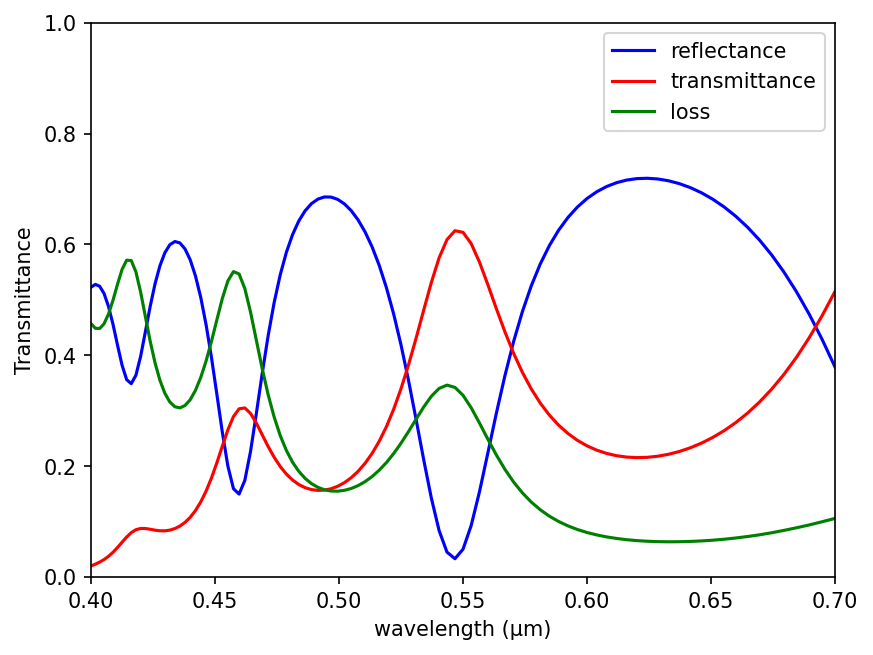

In [20]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Resolution1000.png")

In [21]:
np.savetxt("Reflection_my_code.txt",Rs)
np.savetxt("Transmission_my_code.txt",Ts)